Importing Packages

In [1]:
import numpy as np
import cv2
import os
import pickle
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

Obtaining the Categories

In [2]:
# Set the path to 'training' and 'test' directory
training_dir = './food/train'
test_dir = './food/test'
# Get a list of all folder names in the directory
categories = [name for name in os.listdir(training_dir) 
                if os.path.isdir(os.path.join(training_dir, name))]
print(categories)

['baklava', 'caesar_salad', 'cheesecake', 'cheese_sandwich', 'chicken_curry', 'chicken_wings', 'chocolate_cake', 'donuts', 'eggs', 'falafel', 'fish', 'french_fries', 'hamburger', 'hot_dog', 'ice_cream', 'lasagna', 'omelette', 'pizza', 'spaghetti', 'steak', 'sushi']


Preprocessing Data (The Training hasn't started yet)

In [8]:
img_size = 70
training_data = [] # a list consists of image arrays
test_data = [] # a list consists of image arrays
training_label = [] # a list consists of label arrays
dic_category = {} # a dictionary holding a category and its corresponding index for training set
dic_img = {} # a dictionary holding an image name and its corresponding array for test set
def creating_training_data():
    for index, category in enumerate(categories,0):
        dic_category[category] = index
        path = os.path.join(training_dir,category) # path to images in the category
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img)) # converting every image to a matrix
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # converting from BGR to RGB
            img_array = cv2.resize(img_array,(img_size,img_size)) # creating a picture with less quality to increase computation speed
            training_label.append(index)
            training_data.append(img_array/255) # Normalizting (0,1)
def creating_test_data():
        for img in os.listdir(test_dir):
            img_array1 = cv2.imread(os.path.join(test_dir,img)) # converting every image to a matrix
            img_array1 = cv2.cvtColor(img_array1, cv2.COLOR_BGR2RGB) # converting from BGR to RGB
            img_array1 = cv2.resize(img_array1,(img_size,img_size)) # creating a picture with less quality to increase computation speed
            test_data.append(img_array1/255) # Normalizing (0,1)
            dic_img[img] = img_array1/255
creating_training_data()
creating_test_data()

Saving Modified Data (By doing this we don't have to reload images and waste time)

In [12]:
pickle_out = open("training_data.pickle","wb")
pickle.dump(training_data,pickle_out)
pickle_out.close()

pickle_out = open("training_label.pickle","wb")
pickle.dump(training_label,pickle_out)
pickle_out.close()

pickle_out = open("test_data.pickle","wb")
pickle.dump(test_data,pickle_out)
pickle_out.close()

Loading Saved Data

In [3]:
pickle_in = open("training_data.pickle","rb")
training_data = pickle.load(pickle_in)
pickle_in.close()

pickle_in1 = open("training_label.pickle","rb")
training_label = pickle.load(pickle_in1)
pickle_in1.close()

pickle_in = open("test_data.pickle","rb")
test_data = pickle.load(pickle_in)
pickle_in.close()

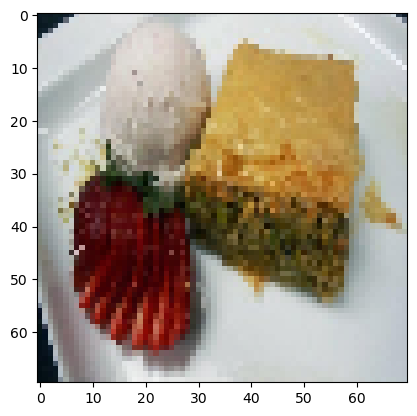

In [4]:
training_data_array = np.array(training_data) # converting list to array
training_data_array = np.squeeze(training_data_array) # eliminate the third dimension

test_data_array = np.array(test_data) # converting list to array
test_data_array = np.squeeze(test_data_array) # eliminate the third dimension

training_label_array = np.array(training_label) # converting list to array
plt.imshow(training_data_array[4])
plt.show()

Training Model Using CNN Algorithm

In [5]:
epochs = 100 # The model will train for 10 full cycles through the dataset
batch_size = 32 # The dataset will be split into batches of 32 samples each
learning_rate = 0.0001

# Shuffle Data
training_data_array, training_label_array = shuffle(training_data_array, training_label_array, random_state=42)

# Data Augmentation To Prevent Overfitting
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1,  # Set aside 10% for validation
)

# Train and Validation Generators
train_generator = train_datagen.flow(training_data_array, training_label_array, batch_size=batch_size, subset='training')
validation_generator = train_datagen.flow(training_data_array, training_label_array, batch_size=batch_size, subset='validation')


# Model Architecture

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=training_data_array.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, kernel_regularizer='l2'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

model.add(Dense(len(categories)))
model.add(Activation('softmax'))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) # if the validation accuracy does not improve for 5 consecutive epochs, the training will stop

# Training the model
model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

c:\Users\asus\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\asus\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


494/494 ━━━━━━━━━━━━━━━━━━━━ 288s 574ms/step - accuracy: 0.0822 - loss: 5.8915 - val_accuracy: 0.1123 - val_loss: 4.6750
Epoch 2/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 281s 568ms/step - accuracy: 0.1089 - loss: 4.9686 - val_accuracy: 0.1801 - val_loss: 4.0704
Epoch 3/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 282s 570ms/step - accuracy: 0.1288 - loss: 4.5645 - val_accuracy: 0.1652 - val_loss: 4.0766
Epoch 4/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 281s 568ms/step - accuracy: 0.1350 - loss: 4.4006 - val_accuracy: 0.2103 - val_loss: 3.8007
Epoch 5/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 280s 567ms/step - accuracy: 0.1476 - loss: 4.2064 - val_accuracy: 0.1983 - val_loss: 3.6598
Epoch 6/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 282s 569ms/step - accuracy: 0.1600 - loss: 4.0140 - val_accuracy: 0.2131 - val_loss: 3.5305
Epoch 7/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 282s 571ms/step - accuracy: 0.1677 - loss: 3.8706 - val_accuracy: 0.1932 - val_loss: 3.5009
Epoch 8/100
494/494 ━━━━━━━━━━━━━━━━━━━━ 282s 570ms/step - accuracy: 0.1735 - los

In [6]:
model.save('food_model.h5')

Prediction

In [9]:
test_file_names = [] # A list to restore the name of test images
predicted_labels = [] # A list to restore the name of predicted labels
loaded_model = tf.keras.models.load_model('food_model.h5')

for img in os.listdir(test_dir):
    test_file_names.append(img)
    c = dic_img[img]
    c = np.expand_dims(c, axis=0) # add an extra dimension to use 'predict' function
    prediction = loaded_model.predict(c) # predict the image array
    predicted_class = np.argmax(prediction, axis=-1)  # Get the index of the highest probability
    tmp = [key for key, value in dic_category.items() if value == predicted_class] # convert index to class label    
    predicted_labels += tmp

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

Export Prediction Data As a CSV File

In [10]:


output = pd.DataFrame({
    'file': test_file_names,  
    'prediction': predicted_labels
})
# Save to CSV
output_file = 'predictions.csv'
output.to_csv(output_file, index=False)